In [1]:
from typing import List, TypedDict
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv


load_dotenv()

True

In [2]:
docs = (
    PyPDFLoader("./docs/book1.pdf").load() +
    PyPDFLoader("./docs/book2.pdf").load() +
    PyPDFLoader("./docs/book3.pdf").load()
)

In [3]:
len(docs)

2123

In [4]:
chunks = RecursiveCharacterTextSplitter(chunk_size = 900, chunk_overlap = 150).split_documents(docs)

for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [5]:
len(chunks)

6396

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store  = FAISS.from_documents(chunks, embeddings)

In [7]:
retriver = vector_store.as_retriever(search_type="similarity" , search_kwargs = {'k':4})

llm = init_chat_model("gpt-4o")



In [8]:
class State(TypedDict):
    question: str
    docs: List[Document]
    answer: str


In [9]:
def retreive(state):
    q = state["question"]
    return {
        "docs" : retriver.invoke(q)
    }

In [10]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer from the context provided,"),
        ("human", "Question: {question}\n\n Context:\n{context}"),
    ]
)

def generate(state):
    context = "\n\n".join(d.page_content for d in state["docs"])
    out = (prompt | llm).invoke({
        "question": state["question"], "context": context
    })

    return {
        "answer": out.content
    }

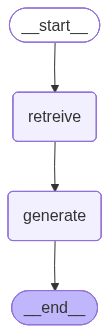

In [11]:
g = StateGraph(State)

g.add_node("retreive", retreive)
g.add_node("generate", generate)

g.add_edge(START, "retreive")
g.add_edge("retreive", "generate")
g.add_edge("generate", END)

app = g.compile()
app

In [12]:
res = app.invoke({
    "question": "Explain the bias-variance trdeoff", 
    "docs": [],
    "answer" : ""
})
print(res["answer"])

The bias-variance tradeoff is a fundamental concept in statistics and machine learning that describes the balance between two types of errors that a model can have when making predictions:

1. **Bias**: This error component arises from the model's assumptions about the underlying data. For example, if a model assumes that data is linear when it is actually quadratic, the model will have high bias. High bias typically leads to underfitting, where the model is too simplistic to capture the underlying patterns in the training data.

2. **Variance**: This error component is due to the model's sensitivity to fluctuations in the training data. A model with high variance will perform well on training data but poorly on new, unseen data because it captures noise and anomalies in the training set. This typically occurs in models with too many degrees of freedom, leading to overfitting.

The challenge in model development is to find a balance between bias and variance that minimizes the generali

In [13]:
res = app.invoke({
    "question": "Explain the bias-variance tradeoff"
})

print(res["answer"])

The bias-variance tradeoff is a fundamental concept in machine learning and statistics, which describes the tradeoff between two sources of error that affect the performance of predictive models:

1. **Bias**: Bias refers to the error due to overly simplistic assumptions in the learning algorithm. For example, assuming that a relationship is linear when it is actually more complex such as quadratic. High bias can cause an algorithm to miss the relevant relations between features and target outputs, leading to underfitting, where the model is unable to capture the underlying trend of the data.

2. **Variance**: Variance describes how much the predictions for a given data point would differ if different training data was used. A model with high variance pays a lot of attention to the training data and is highly sensitive to fluctuations in the training set. This can lead to overfitting, where the model learns the noise of the training data as if it were part of the true signal.

The key 

In [14]:
# print(res["docs"][0].page_content)
# print("*"*100)
# print(res["docs"][1].page_content)
# print("*"*100)
# print(res["docs"][2].page_content)
# print("*"*100)
# print(res["docs"][3].page_content)
# print("*"*100)

# # based on my question about transformer the docs retrieved does not match with query not even single docs buit still i get answer (thats based on llm  pre-trained wighr)
# # CRAG solves this problem
# # to make sure the retrived docs are levraged to answer
